<a href="https://colab.research.google.com/github/sandakalum/SPH6004_Project_2/blob/master/Death_LOS_Classification(48_hours)_Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, LSTM, Conv1D, MaxPool1D, TimeDistributed, Bidirectional,MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from pathlib import Path
import os
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
import random as rn

#added
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
#from keras.optimizers import adam
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import AUC

#For ROC calculation
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#For reproducable results
tf.random.set_seed(1234)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
#Mount Google Drive to read data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# x = pd.read_csv("/content/drive/My Drive/Data/x_AllData.csv")    
# y = pd.read_csv("/content/drive/My Drive/Data/y_AllData.csv")  
x_in = pd.read_csv("/content/drive/My Drive/Data/x_AllData_NOzero.csv")    
y_in = pd.read_csv("/content/drive/My Drive/Data/y_AllData_NOzero.csv")  

#Drop people with LOS < 24 (1 day)
idx = y_in[y_in['LOS_ICU'] <= 24].index
x_in = x_in.drop(idx)
y_in = y_in.drop(idx)

#Drop people with LOS > 24*30 (30 day)
idx = y_in[y_in['LOS_ICU'] >= 24*30].index
x_in = x_in.drop(idx)
y_in = y_in.drop(idx)

x_in = x_in.drop('Unnamed: 0', axis=1)

#Drop people who were discharged
idx = y_in[y_in['icustay_expire_flag'] == 0].index
x_in = x_in.drop(idx)
y_in = y_in.drop(idx)

x = x_in
y = y_in
print(x.shape)
print(y.shape)

# For graphs
idx_1 = (y['LOS_ICU']<=24*2)
idx_0 = (y['LOS_ICU']>24*2)

# Mortality within next 24 hours
y = y['LOS_ICU']
y[y<=24*2] = 1
y[y>24*2] = 0

np.histogram(y)

(2105, 125)
(2105, 4)


(array([1710,    0,    0,    0,    0,    0,    0,    0,    0,  395]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [0]:
def reshape_features(x,features,timestamps):
  x  = x.to_numpy()
  patients = x.shape[0]
  timestamps = int(x.shape[1]/features)
  df = np.empty([patients, timestamps, features], dtype=float)
  for i in range(0,features):
    df[:,:,i] = x[:,(i*25):(i*25+timestamps)]
  return df

#Reshape x into 3D tensor

features = 5
timestamps = 25
x = reshape_features(x,features,timestamps)

Plot mean variation for each feature for different mortality and LOS conditions

In [0]:
#   patient_0 = np.mean(x[idx_0,:,:], axis = 0)
#   patient_1 = np.mean(x[idx_1,:,:], axis = 0)
#   vital_names = ['DiasBP(mmHg)','Heart Rate(BPM)','MeanBP(mmHg)','SpO2(%)','SysBP(mmHg)']
#   i = 4
#   from google.colab import files
# # for i in [0,1,2,3,4]:
#   plt.plot(patient_0[:,i], label='LOS > 48 hours')
#   plt.plot(patient_1[:,i], label='LOS ≤ 48 hours')
#   plt.title('Variation of '+ vital_names[i])
#   plt.xlabel('Hour in ICU')
#   plt.ylabel(vital_names[i])
#   plt.legend(loc="upper right")
#   plt.savefig(vital_names[i] + '.png', bbox_inches='tight', format='png', dpi=300)
#   # plt.rcParams.update({'font.size': 20})
#   # files.download(vital_names[i] + '.png')
#   # plt.show()

In [0]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 25)
y_test.shape

(421,)

In [0]:
# from sklearn.utils import class_weight
# # Calculate class weights 
# class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weights = dict(enumerate(class_weights))

In [0]:
def genData(x,y):
  from sklearn.model_selection import train_test_split
  # #Generate synthetic samples
  from imblearn.over_sampling import SMOTE
  sm = SMOTE(random_state=27, ratio=1.0)
  features = x.shape[2]
  # df = np.array([], dtype=int)
  for i in range(0,features):
    x_gen, y_gen = sm.fit_sample(x[:,:,i],y)
    x_gen = x_gen.reshape((x_gen.shape[0],x_gen.shape[1],1))
    print(i)
    if i == 0:
      X_train = x_gen
      y_train = y_gen
    else:
      X_train = np.concatenate([X_train, x_gen],axis=2)
  return X_train, y_train


In [0]:
# # Oversampling training data
X_train, y_train = genData(X_train,y_train)
# # Oversampling test data
# X_test, y_test = genData(X_test,y_test)

0
1
2
3
4


In [0]:
print(X_train.shape)
np.histogram(y_train)

(2736, 25, 5)


(array([1368,    0,    0,    0,    0,    0,    0,    0,    0, 1368]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [0]:
print(X_test.shape)
np.histogram(y_test)

(421, 25, 5)


(array([342,   0,   0,   0,   0,   0,   0,   0,   0,  79]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [0]:
#Split data
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 25)
print(X_train.shape)
np.histogram(y_train)

(2188, 25, 5)


(array([1094,    0,    0,    0,    0,    0,    0,    0,    0, 1094]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'     
# define callbacks
cp = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 0, save_best_only = True, mode ='auto')
es = EarlyStopping(monitor='val_loss', patience= 5, verbose=1)
callbacks_list = [es]

In [0]:
def get_recurrentModel(in_shape, n_classes):
    """
    input data shape for recurrent network: (n , time, features)
    """
    model = Sequential()
    model.add(LSTM(100, input_shape=in_shape))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='sigmoid'))
    Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(), 'accuracy'])
    model.summary()
    return model

#Build model
in_shape = (X_train.shape[1], X_train.shape[2])
    
model = get_recurrentModel(in_shape, 1)

#Remove Previous models
for filename in os.listdir():
    if filename.endswith('.hdf5'):
        os.remove(filename)
        print(filename)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 52,601
Trainable params: 52,601
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
22/22 [==============================] - 1s 32ms/step - loss: 0.7051 - auc: 0.5359 - accuracy: 0.5288 - val_loss: 0.6748 - val_auc: 0.6201 - val_accuracy: 0.5420
Epoch 2/50
22/22 [==============================] - 0s 7ms/step - loss: 0.6790 - auc: 0.5958 - accuracy: 0.5750 - val_loss: 0.6583 - val_auc: 0.6329 - val_accuracy: 0.6040
Epoch 3/50
22/22 [==============================] - 0s 7ms/step - loss: 0.6642 - auc: 0.6298 - accuracy: 0.5978 - val_loss: 0.6505 - val_auc: 0.6449 - val_accuracy: 0.6168
Epoch 4/50
22/22 [==============================] - 0s 7ms/step - loss: 0.6552 - auc: 0.6451 - accuracy: 0.6042 - val_loss: 0.6439 - val_auc: 0.6409 - val_accuracy: 0.6241
Epoch 5/50
22/22 [==============================] - 0s 6ms/step - loss: 0.6530 - auc: 0.6487 - accuracy: 0.6028 - val_loss: 0.6437 - val_auc: 0.6503 - val_accuracy: 0.5967
Epoch 6/50
22/22 [==============================] - 0s 6ms/step - loss: 0.6516 - auc: 0.6493 - accuracy: 0.6028 - val_loss: 0.6398 - val_au

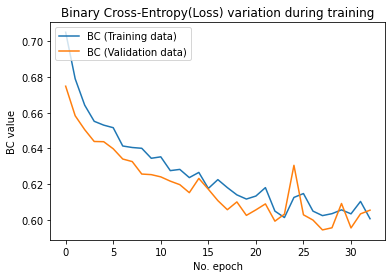

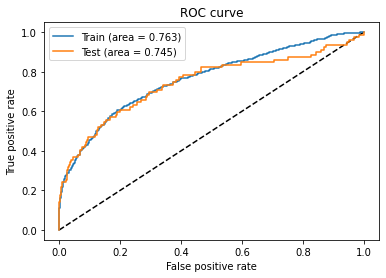

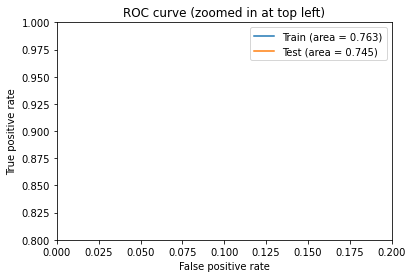

Accuracy: 0.655582
Precision: 0.318681
Recall: 0.734177
F1 score: 0.444444
Cohens kappa: 0.247519
ROC AUC: 0.744948
[[218 124]
 [ 21  58]]


In [0]:
# Train model
hist = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data = (X_validation, y_validation), verbose=1, callbacks=callbacks_list)      

#Plot training history
def plotHist(history):
    plt.plot(history.history['loss'], label='BC (Training data)')
    plt.plot(history.history['val_loss'], label='BC (Validation data)')
    plt.title('Binary Cross-Entropy(Loss) variation during training')
    plt.ylabel('BC value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    # plt.savefig("BC.png", bbox_inches='tight', format='png', dpi=300)
    #files.download("BC.png")
    plt.show()
from google.colab import files
plotHist(hist)

#Plot ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#ROC curve for train
y_pred_keras = model.predict(X_train).ravel()
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_keras)

auc_traindata = auc(fpr_train, tpr_train)

#ROC curve for test
y_pred_keras2 = model.predict(X_test).ravel()
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_keras2)

auc_testdata = auc(fpr_test, tpr_test)

#Plot ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_train, tpr_train, label='Train (area = {:.3f})'.format(auc_traindata))
plt.plot(fpr_test, tpr_test, label='Test (area = {:.3f})'.format(auc_testdata))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("ROC.png", bbox_inches='tight', format='png', dpi=300)
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_train, tpr_train, label='Train (area = {:.3f})'.format(auc_traindata))
plt.plot(fpr_test, tpr_test, label='Test (area = {:.3f})'.format(auc_testdata))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# Calculate confusion matrix
predictions = model.predict(X_test)
pred = model.predict(X_test)
predictions[predictions>0.5] = 1
predictions[predictions<0.5] = 0
predictions.astype(int)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)



Train the model several times to get a good understanding of the performance

In [0]:
  # fit and evaluate a model
def evaluate_model(X_train, y_train, X_test, y_test, n_batch):
	# fit network
	model.fit(X_train, y_train, epochs=50, batch_size=n_batch, validation_data = (X_validation, y_validation), verbose=0, callbacks=callbacks_list)
	# evaluate model
	_, AUC_ROC, Acc = model.evaluate(X_test, y_test)
	return AUC_ROC, Acc

# summarize scores
def summarize_results(scores,metric_type):
	print(scores)
	m, s = np.mean(scores), np.std(scores)
	print(metric_type+': %.3f%% (+/-%.3f)' % (m, s))

repeats = 10
# repeat experiment
scores = list()
accuracies = list()
n_batch = [10, 50, 100, 500, 1000, 5000] 
# for r in range(len(n_batch)):
# 	score, acc = evaluate_model(X_train, y_train, X_test, y_test, n_batch[r])
	# print(n_batch[r])
for r in range(repeats):
	score, acc = evaluate_model(X_train, y_train, X_test, y_test, 100)
	score = score * 100.0
	acc = acc*100.0
	print('>#%d: %.3f' % (r+1, score))
	scores.append(score)
	accuracies.append(acc)
	# summarize results
summarize_results(scores,'AUC')
summarize_results(accuracies,'Accuracy')

Epoch 00025: early stopping
14/14 [==============================] - 0s 3ms/step - loss: 0.7531 - auc: 0.7154 - accuracy: 0.5202
>#1: 71.545
Epoch 00006: early stopping
14/14 [==============================] - 0s 3ms/step - loss: 0.6045 - auc: 0.7101 - accuracy: 0.7245
>#2: 71.014
Epoch 00012: early stopping
14/14 [==============================] - 0s 3ms/step - loss: 0.7115 - auc: 0.7168 - accuracy: 0.5867
>#3: 71.684
Epoch 00013: early stopping
14/14 [==============================] - 0s 4ms/step - loss: 0.5806 - auc: 0.7264 - accuracy: 0.7173
>#4: 72.642
Epoch 00012: early stopping
14/14 [==============================] - 0s 3ms/step - loss: 0.7235 - auc: 0.7234 - accuracy: 0.5914
>#5: 72.341
Epoch 00007: early stopping
14/14 [==============================] - 0s 3ms/step - loss: 0.6137 - auc: 0.7125 - accuracy: 0.6912
>#6: 71.251
Epoch 00012: early stopping
14/14 [==============================] - 0s 3ms/step - loss: 0.6483 - auc: 0.7198 - accuracy: 0.6603
>#7: 71.976
Epoch 00007: 

In [0]:
# model.save_weights("/content/drive/My Drive/")